In [1]:
!pwd

/Users/nico/panoseti/panoseti-software/cloud-detection/anomaly_detection


In [326]:
import sys, os
import logging, typing

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


import torch
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
sys.path.append('../../util')
import panoseti_file_interfaces as pfi
import pff
from vae_model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [276]:
def load_ph_data(data_dir, run_dir, module_id):
    """
    [DEPRECATED]
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in tqdm(frame_iterator, unit='frames'):
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    
    return ph_df


def load_ph_data_lazy(data_dir, run_dir, module_id):
    """
    Generator for PH events in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return None
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in frame_iterator:
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                j['unix_timestamp'] = pd.to_datetime(float(j['wr_timestamp (s)']), unit = 's', utc=True)
                j['img_data'] = img
                yield j

In [277]:
data_dir = './test_data'
run_dir = 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd'

ph1_gen = load_ph_data_lazy(data_dir, run_dir, 1)
pfi.ObservingRunInterface(data_dir, run_dir).obs_pff_files

{1: {'img': [],
  'ph': [{'fname': 'start_2024-07-25T04_34_46Z.dp_ph256.bpp_2.module_1.seqno_0.pff',
    'seqno': 0,
    'nframes': 265275,
    'first_unix_t': 1721882094.288621,
    'last_unix_t': 1721895587.1269574}],
  'baseline_df': None},
 3: {'img': [],
  'ph': [{'fname': 'start_2024-07-25T04_34_46Z.dp_ph256.bpp_2.module_3.seqno_0.pff',
    'seqno': 0,
    'nframes': 261742,
    'first_unix_t': 1721882093.3920617,
    'last_unix_t': 1721895587.968187}],
  'baseline_df': None}}

In [278]:
# Pulse Height Exploratory Data Analysis (EDA) constants
MAX_PH_VAL = 2**16 - 1
OUTLIER_CUTOFF = MAX_PH_VAL - 1000
clip_z_score = 5

def clean_ph_img(ph_img, outlier_strategy='zero'):
    """Set outlier pulse heigh pixel values to 0.
    Arguments:
        ph_img: raw pulse-height image
        outlier_strategy: how to deal with outliers
            'zero' => set outliers to 0
            'clip' => clip outlier values to some max value
    """
    # Remove outliers
    assert outlier_strategy in ['zero', 'clip']
    if outlier_strategy == 'zero':
        ph_img_clean = ph_img.copy()
        ph_img_clean[ph_img >= OUTLIER_CUTOFF] = 0
    elif outlier_strategy == 'clip':
        inlier_mean = np.mean(ph_img[ph_img < OUTLIER_CUTOFF])
        inlier_std = np.std(ph_img[ph_img < OUTLIER_CUTOFF])
        clip_max_pixel_val = inlier_mean + clip_z_score * inlier_std
        
        ph_img_clean = ph_img.copy()
        ph_img_clean = np.clip(ph_img_clean, 0, clip_max_pixel_val)

    # PH image should not be all zeros
    max_pixel_val = np.max(ph_img_clean)
    if max_pixel_val == 0:
        logger.warning('All PH pixels are zero')
        return None, 0
    ph_img_clean = ph_img_clean / max_pixel_val
    return ph_img_clean, max_pixel_val

def plot_ph_pixel_dist(ph_img_clean, max_pixel_val, ax=None):
    """Plot pulse height pixel distribution (for EDA outlier rejection)."""
    sns.histplot(ph_img_clean.ravel() * max_pixel_val, stat='density', ax=ax)
    if ax:
        ax.set_title(f"Distribution of PH pixels from Q{j['quabo_num']} at \n{j['unix_timestamp']}")

def plot_ph_img(ph_img_clean, max_pixel_val, ax=None):
    if ax is None:
        f = plt.figure()
        ax = plt.gca()
    img = ax.imshow(ph_img_clean * max_pixel_val, cmap='rocket')
    plt.colorbar(img, fraction=0.045)

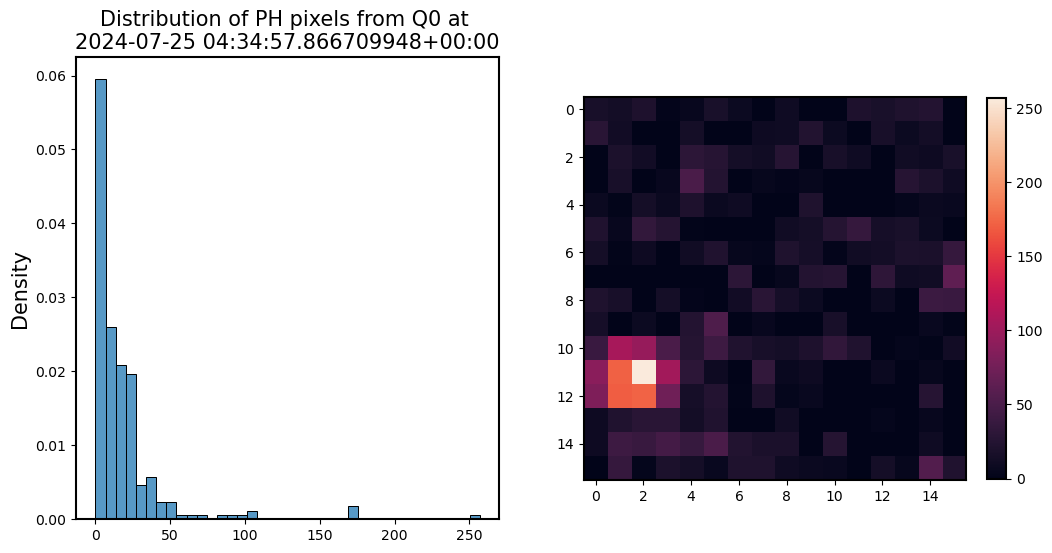

In [284]:
# Lazily get next pulse height image
j = next(ph1_gen)
ph_img = j['img_data']
ph_img_clean, max_pixel_val = clean_ph_img(ph_img)

if ph_img_clean is not None:
    f, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_ph_img(ph_img_clean, max_pixel_val, ax=axs[1])
    plot_ph_pixel_dist(ph_img_clean, max_pixel_val, ax=axs[0])
    
    plt.show()

In [545]:
ph_dataset_config = {
    "data_dir": './test_data',
    "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
    "module_ids": 'all',
}

class PulseHeightDataset(torch.utils.data.Dataset):
    """Interface for retrieving pulse-height images from a specific observing run."""
    MAX_PH_VAL = 2**16 - 1
    OUTLIER_CUTOFF = MAX_PH_VAL - 1000  # Value defining pixel outlier status

    def __init__(self, config: typing.Dict, transform=None, target_transform=None, log_level=31):
        super().__init__()
        # Validate configuration dict
        assert {'data_dir', 'run_dir', 'module_ids'}.issubset(set(config.keys()))
        assert len(config['module_ids']) > 0
        self.config = config
        self.ori = pfi.ObservingRunInterface(config['data_dir'], config['run_dir'])
        assert self.ori.obs_pff_files is not None
        assert config['module_ids'] == 'all' or set(config['module_ids']).issubset(set(self.ori.obs_pff_files.keys()))
        
        # Initialize PH frame generator
        if config['module_ids'] == 'all':
            self.dataset_module_ids = self.ori.obs_pff_files.keys()
        else:
            self.dataset_module_ids = config['module_ids']
        self.ph_gen = self.ph_generator()

        self.logger = logging.getLogger("PulseHeightDataset")
        self.logger.setLevel(log_level)

    def ph_generator(self):
        self.__ph_generators = {module_id: self.load_ph_data_lazy(data_dir, run_dir, module_id) for module_id in self.dataset_module_ids}
        for module_id in self.dataset_module_ids:
            for j in self.__ph_generators[module_id]:
                ph_img = j['img_data']
                del j['img_data']
                ph_img_clean, max_pixel_val = self.clean_ph_img(ph_img)
                if ph_img_clean is None:
                    continue
                yield {'meta': j, 'img': ph_img_clean, 'max_pixel_val': max_pixel_val}
    
    def load_ph_data_lazy(self, data_dir: str, run_dir: str, module_id: int):
        """Sequentially yields PH frames from module_id."""
        assert hasattr(self, 'ori')
        if module_id not in self.ori.obs_pff_files:
            print(f'No module with ID "{module_id}"\n'
                  f'Available module_ids:\n\t{list(self.ori.obs_pff_files.keys())}')
            return None
        for ph_file in self.ori.obs_pff_files[module_id]["ph"]:
            fname = ph_file["fname"]
            fpath = f'{data_dir}/{run_dir}/{fname}'
            with open(fpath, 'rb') as fp:
                frame_iterator = self.ori.pulse_height_frame_iterator(fp, 1)
                for j, img in frame_iterator:
                    j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                    j['unix_timestamp'] = pd.to_datetime(float(j['wr_timestamp (s)']), unit = 's', utc=True)
                    j['img_data'] = img
                    yield j

    def clean_ph_img(self, ph_img: np.ndarray, outlier_strategy='zero', clip_z_score=5) -> typing.Tuple[int, int]:
        """Set outlier pulse heigh pixel values to 0.
        Arguments:
            ph_img: raw pulse-height image
            outlier_strategy: how to deal with outliers
                'zero' => set outliers to 0
                'clip' => clip outlier values to a max pixel value given by clip_z_score and inlier mean and standard deviations.
        Returns: 2-element tuple:
            idx 0: pulse-height frame after applying the specified outlier_strategy with pixels normalized to 0-1 
            idx 1: maximum max_pixel_val, represented by the pixel value 1.0
        """
        # Remove outliers
        assert outlier_strategy in ['zero', 'clip']
        if outlier_strategy == 'zero':
            ph_img_clean = ph_img.copy()
            ph_img_clean[ph_img >= OUTLIER_CUTOFF] = 0
        elif outlier_strategy == 'clip':
            inlier_mean = np.mean(ph_img[ph_img < OUTLIER_CUTOFF])
            inlier_std = np.std(ph_img[ph_img < OUTLIER_CUTOFF])
            clip_max_pixel_val = inlier_mean + clip_z_score * inlier_std
            ph_img_clean = ph_img.copy()
            ph_img_clean = np.clip(ph_img_clean, 0, clip_max_pixel_val)
    
        # PH image should not be all zeros
        max_pixel_val = np.max(ph_img_clean)
        if max_pixel_val == 0:
            self.logger.warning('All PH pixels are zero')
            return None, 0
        ph_img_clean = ph_img_clean / max_pixel_val
        return ph_img_clean, max_pixel_val
            
    def __getitem__(self, index: int) -> np.ndarray:
        """Get PH frame at index"""
        try:
            return next(self.ph_gen)
        except StopIteration:
            self.ph_gen = self.ph_generator()
            return next(self.ph_gen)

    def __len__(self) -> int:
        total_ph_frames = 0
        for module_id in self.dataset_module_ids:
            for ph_file in self.ori.obs_pff_files[module_id]['ph']:
                total_ph_frames += ph_file['nframes']
        return total_ph_frames

In [546]:
ph_dataset = PulseHeightDataset(ph_dataset_config, log_level=31)

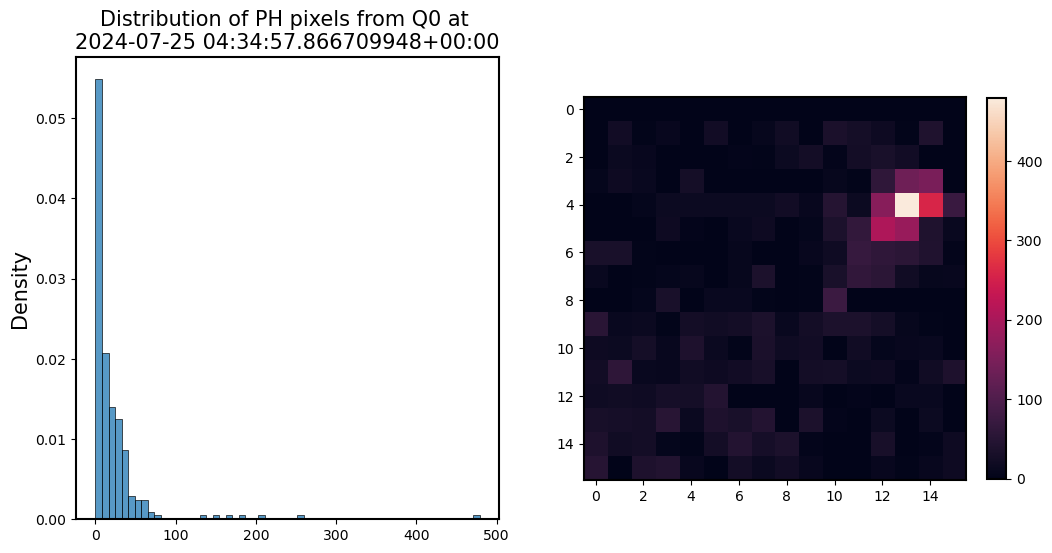

In [565]:
ph_data = ph_dataset[0]
header_metadata = ph_data['meta']
ph_img_clean = ph_data['img']
max_pixel_val = ph_data['max_pixel_val']

assert ph_img_clean is not None

f, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_ph_img(ph_img_clean, max_pixel_val, ax=axs[1])
plot_ph_pixel_dist(ph_img_clean, max_pixel_val, ax=axs[0])

plt.show()

In [566]:
meta

{'quabo_num': 0,
 'pkt_num': 3444,
 'pkt_tai': 531,
 'pkt_nsec': 288621037,
 'tv_sec': 1721882094,
 'tv_usec': 288954,
 'wr_timestamp (s)': Decimal('1721882094.288621037'),
 'unix_timestamp': Timestamp('2024-07-25 04:34:54.288620949+0000', tz='UTC')}